# Assignment 1

# Formalia:

Please read the [assignment overview page](https://laura.alessandretti.com/comsocsci2023/assignments.html) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Feb 28th at 23:55. Hand in your Jupyter notebook file (with extension `.ipynb`) via DTU Learn _(Assignment, Assignment 1)_. 

Remember to include in the first cell of your notebook:
* the link to your group's Git repository (if you don't have a shared Git repository, it's fine. Remember to do it next time)
* group members' contributions

## Part 1: Using web-scraping to gather data

Gather the list of researchers that have joined the most important scientific conference in Computational Social Science in 2019. 

You can find the programmes of the 2019 edition at the links below:  
>Oral presentations: https://2019.ic2s2.org/oral-presentations/    
> Poster presentations: https://2019.ic2s2.org/posters/    

1. Inspect the HTML of the pages above and use web-scraping to get the set of participants in 2019. Share your code and add comments to guide us through it.
2. How many unique researchers you got in 2019?
3. Explain one or two decisions you took during the web-scraping exercise, for 2019 or any other year. Why did you take this choice? How might your decision impact the final number of authors?

We start by checking out the oral presentations. The process for this is cumbersome, and is explained in detail below.

In [2]:
from bs4 import BeautifulSoup
import requests

LINK_2019 = "https://2019.ic2s2.org/oral-presentations/"
r_2019 = requests.get(LINK_2019) 
r_2019.content
soup_2019 = BeautifulSoup(r_2019.content)

Now, the side has been loaded in, and it is time to extract the relevant data. From inspecting the page manually, we find that we should search for all the paragraphs.

In [146]:
data = soup_2019.find_all('p')
step0 = data[4]
step0


<p><strong>1B Culture and Art</strong> – Thursday July 18, 11:00 – 12:30 <br/><em>Chair: Milan Janosov</em><br/>11:00 – 11:15 – Kangsan Lee, Jaehyuk Park, Yong-Yeol Ahn. Valuing Art: Professional vs. Algorithm<br/>11:15 – 11:30 – Milan Janosov, Federico Battiston, Gerardo Iñiguez, Federico Musciotto. Success and mentorship in electronic music<br/>11:30 – 11:45 – Sophie Cho, Michael Mauskapf. Unpacking the Ecological Dynamics of Cultural Products: Evidence from Popular Music<br/>11:45 – 12:00 – Susumu Nagayama, Hitoshi Mitsuhashi. Expandable and Extendable Root Concepts<br/>12:00 – 12:15 – Ramona Roller, Frank Schweitzer. Network regression reveals factors driving the letter communication of 16th century reformators<br/>12:15 – 12:30 – No Presentation</p>

Now, we have to work some magic to extract the names. First, we can split the above on the word ```'Chair'```, which yields: 

In [147]:
step1 = str(step0)
step2 = step1.split('Chair: ')
step2

['<p><strong>1B Culture and Art</strong> – Thursday July 18, 11:00 – 12:30 <br/><em>',
 'Milan Janosov</em><br/>11:00 – 11:15 – Kangsan Lee, Jaehyuk Park, Yong-Yeol Ahn. Valuing Art: Professional vs. Algorithm<br/>11:15 – 11:30 – Milan Janosov, Federico Battiston, Gerardo Iñiguez, Federico Musciotto. Success and mentorship in electronic music<br/>11:30 – 11:45 – Sophie Cho, Michael Mauskapf. Unpacking the Ecological Dynamics of Cultural Products: Evidence from Popular Music<br/>11:45 – 12:00 – Susumu Nagayama, Hitoshi Mitsuhashi. Expandable and Extendable Root Concepts<br/>12:00 – 12:15 – Ramona Roller, Frank Schweitzer. Network regression reveals factors driving the letter communication of 16th century reformators<br/>12:15 – 12:30 – No Presentation</p>']

We only care about the part after the split, i.e ```step2[-1]```, so this becomes step3. Also, we split on ```'<br/>'```, which yields.

In [148]:
step3 = step2[-1]
step4 = step3.split('<br/>')
step5 = step4[1:] # Ignore the Chair name
step6 = step5[0].split('– ') # Split on the dash to remove the time
step7 = step6[-1].split(', ') # Split on the comma to seperate the authors
step8 = step7[-1]
step9 = step8.split('.')[0]

authors = []
authors.extend(step7[:-1])
authors.extend([step9])
authors

['Kangsan Lee', 'Jaehyuk Park', 'Yong-Yeol Ahn']

All this is only an example on one paragraph. However, we can write a function to do all of this at once.

In [149]:
def scraperv1(url: str) -> list:
    r = requests.get(url) 
    soup = BeautifulSoup(r.content)
    data = soup.find_all('p')[3:] # Ignore the first 3 entries

    authors = []

    for entry in data:
        step1 = str(entry)
        if '<strong>' not in step1: # Check if the entry is a presentation
            continue
        
        step2 = step1.split('Chair: ')
        step3 = step2[-1]
        step4 = step3.split('<br/>')
        presentaions = step4[1:] # Ignore the Chair name (step5)
        for presentation in presentaions:
            step6 = presentation.split('– ') # Split on the dash
            step7 = step6[-1].split(', ') # Split on the comma
            step8 = step7[-1]
            step9 = step8.split('.')[0]
            authors.extend(step7[:-1])
            authors.extend([step9])

    
    return authors

In [160]:
raw_authors = scraperv1(LINK_2019)
print(raw_authors[:20],'\n',f"Number of authors {len(raw_authors)}")


['Jieyu Ding', 'Qiusi Sun', 'Jingwen Zhang', 'Mahmoudreza Babaei', 'Juhi Kulshrestha', 'Abhijnan Chakraborty', 'Elissa M. Redmiles', 'Meeyoung Cha', 'Krishna Gummadi', 'Alexandre Bovet', 'Hernan Makse', 'Ziv Epstein', 'Mohsen Mosleh', 'Antonio Arechar', 'Gordon Pennycook', 'David Rand', 'Sunandan Chakraborty', 'Tarunima Prabhakar', 'Joyojeet Pal –', 'Dissecting Fake News: Understanding the Dynamics of False Information spread in India'] 
 Number of authors 698


Inspecting the list of authors above, it is evident there are some flaws in our methods most noticably the titles appearing. We can try to filter these out.

In [164]:
import numpy as np
lens = [len(author) for author in authors]
mu = np.mean(lens)
filtered_authors = [author for author in authors if len(author) < mu*2]
print(filtered_authors[:20],'\n',f"Number of authors {len(filtered_authors)}")

['Jieyu Ding', 'Qiusi Sun', 'Jingwen Zhang', 'Mahmoudreza Babaei', 'Juhi Kulshrestha', 'Abhijnan Chakraborty', 'Elissa M. Redmiles', 'Meeyoung Cha', 'Krishna Gummadi', 'Alexandre Bovet', 'Hernan Makse', 'Ziv Epstein', 'Mohsen Mosleh', 'Antonio Arechar', 'Gordon Pennycook', 'David Rand', 'Sunandan Chakraborty', 'Tarunima Prabhakar', 'Joyojeet Pal –', 'Gustavo Jota Resende'] 
 Number of authors 667


We see there are some errors with a dash being at the end of a name. We can simply fix this.

In [165]:
clean_authors = [name if name[-1] != '–' else name[:-2] for name in filtered_authors] # Remove the dash at the end of the name
print(clean_authors[:20],'\n',f"Number of authors {len(clean_authors)}")

['Jieyu Ding', 'Qiusi Sun', 'Jingwen Zhang', 'Mahmoudreza Babaei', 'Juhi Kulshrestha', 'Abhijnan Chakraborty', 'Elissa M. Redmiles', 'Meeyoung Cha', 'Krishna Gummadi', 'Alexandre Bovet', 'Hernan Makse', 'Ziv Epstein', 'Mohsen Mosleh', 'Antonio Arechar', 'Gordon Pennycook', 'David Rand', 'Sunandan Chakraborty', 'Tarunima Prabhakar', 'Joyojeet Pal', 'Gustavo Jota Resende'] 
 Number of authors 667


Last, we take the set to remove potential duplicates, and save the authors to a df.

In [232]:
import pandas as pd
import pickle
import os

authors_oral = list(set(clean_authors)) # Remove duplicates
df = pd.DataFrame(authors_oral, columns=['Authors'])

if not os.path.exists('author_data'):
   os.makedirs('author_data')

df.to_csv('author_data/authors_oral.csv', index=False)
with open('author_data/authors_oral.pickle', 'wb') as f:
    pickle.dump(df, f)

print(f"Number of authors {len(authors_oral)}")

Number of authors 549


Hence, we find a total of 549 authors from the 2019 oral prensentations. This is not guaranteed to only contain names, and there might still be flaws with the names themselves.

Next, we will go through the poster presentations.

In [177]:
def scraperv2(url: str) -> list:
    authors = []
    
    r = requests.get(url) 
    soup = BeautifulSoup(r.content)
    data = soup.find_all('li') # Get all the list items
    texts = [line.text for line in data] # Get the text from the list items

    temp = []
    for line in texts:
        temp.extend(line.split("\xa0\n")) # Split on the non-breaking space character and new line character
    
    temp1 = temp[32:360] # Ignore the first 32 entries and the last 24 entries
    temp2 = []
    for line in temp1:
        temp2.extend(line.split("\xa0")) # Split on the non-breaking space character

    temp3 = []
    for line in temp2: 
        temp3.extend(line.split("\n")) # Split on the new line character

    names = temp3[::2] # Get every other entry

    temp4 = []
    for line in names: 
        temp4.extend(line.split(",")) # Split on the comma

    temp5 = []
    for line in temp4:
        temp5.extend(line.split("and ")) # Split on the word "and"

    temp6 = list(set(temp5)) # Remove duplicates
    temp6.remove("") # Remove empty strings

    for line in temp6:
        authors.append(line[1:]) if line[0] == " " else authors.append(line) # Remove the space at the beginning of the name

    authors = list(set(authors)) # Remove duplicates
    authors.remove("") # Remove empty strings

    return authors




We run the function to get the authors from the 2019 poster presentations.

In [188]:
LINK_POSTER = "https://2019.ic2s2.org/posters/"

authors_poster = scraperv2(LINK_POSTER)
df2 = pd.DataFrame(authors_poster, columns=['Authors'])
df2.to_csv('author_data/authors_poster.csv', index=False)
with open('author_data/authors_poster.pickle', 'wb') as f:
    pickle.dump(df2, f)

print(f"We find {len(authors_poster)} authors.")

We find 475 authors.


We combine the two lists of authors.

In [195]:
total_authors = final_authors + authors_poster
total_authors.remove('No presentation</p>')
total_authors = list(set(total_authors))
print(f"In total, we find {len(total_authors)} unique authors in 2019.")

In total, we find 949 unique authors in 2019.


In conclusion, we find a total of 949 authors from the oral and poster presentations fro 2019. This of course included many decisions for filtering, and many of these decisions might not have been optimal. However, the layout of the two websites made it very tedious to gather only the information you want without also removing some in the process. A great example is when we filter the names from oral presentations after the length to remove presentation titles. This might have an unwanted effect of also removing some long names, and might not even have removed all the non-names. Unfortunately, that is a trade-off, that must be made.

#### 2020 and 2021

We also gathered the authors from 2020 and 2021. This code will not be commented but results will be shown.
We start with 2020 which included a Google Sheets document.

In [197]:
LINK = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTX9_1Xftn7D-nSI8X9b7tafr_Z0kAbphKdfZ8qUSU9p-syXNsGPdhHl5ZyTnKKL-T6dCEJqtsrn3wy/pubhtml/sheet?headers=false&gid=181378784"
r = requests.get(LINK) 
soup = BeautifulSoup(r.content) 

class_name =  "waffle"
table = soup.find("table",{"class": class_name})
rows = table.find_all("tr") 
names = rows[3].find_all("td", {"class": "s1"})
print(names)

[<td class="s1">Tutorial</td>, <td class="s1">Tutorial: Identifying social media manipulation with OSoMe tools</td>, <td class="s1">Diogo Pacheco, Kaicheng Yang, Pik-mai Hui</td>, <td class="s1">July 17, 2020, 02:00:00 PM</td>, <td class="s1">July 17, 2020, 05:00:00 PM</td>]


In [202]:
all_names = []
boole = []
for row in rows[2:]:
    stuff = row.find_all("td", {"class": "s1"})
    if stuff[2].text != '':
        all_names.append(stuff[2].text.split(', '))

final_names = []
for name in all_names:
    final_names.extend(name)

In [214]:
authors_2020 = list(set(final_names))

print(f"We find {len(authors_2020)} authors in 2020.")

We find 990 authors in 2020.


In [205]:
df3 = pd.DataFrame(final_names, columns=['Authors'])
df3.to_csv('author_data/authors_2020.csv', index=False)
with open('author_data/authors_2020.pickle', 'wb') as f:
    pickle.dump(df3, f)

In [207]:
LINK = "https://easychair.org/smart-program/IC2S2-2021/talk_author_index.html"
r = requests.get(LINK) 
soup = BeautifulSoup(r.content) 

class_name =  "index"
table = soup.find("table",{"class": class_name})
temp = table.find_all("td", {"class": "name"})
names = []
for name in temp:
    both = name.text.split(', ')
    names.append(both[1]+" "+both[0])

In [215]:
authors_2021 = list(set(names))
print(f"We find {len(authors_2021)} authors in 2021.")

We find 692 authors in 2021.


In [210]:
df4 = pd.DataFrame(names_2021, columns=['Authors'])
df4.to_csv('author_data/authors_2021.csv', index=False)
with open('author_data/authors_2021.pickle', 'wb') as f:
    pickle.dump(df4, f)

We finally collect all authors in one dataframe. This will be the basis of the part 2.

In [219]:
authors = authors_oral + authors_poster + authors_2020 + authors_2021
unique_authors = list(set(authors))
print(f"In total, we find {len(unique_authors)} unique authors across all years (2019, 2020, 2021).")

In total, we find 2261 unique authors across all years (2019, 2020, 2021).


In [220]:
df_authors = pd.DataFrame(unique_authors, columns=['Authors'])
df_authors.to_csv('authors.csv', index=False)
with open('authors.pickle', 'wb') as f:
    pickle.dump(df_authors, f)

## Part 2: Getting data from the Semantic Scholar API

> * Consider the list of author ids you have found in Week 2, Part 3, first excercise. For each author, use the Academic Graph API to find:
>    - their _aliases_
>    - their _name_
>    - their _papers_, where for each paper we want to retain: 
>        -  _title_ 
>        -  _abstract_ 
>        -  the _year_ of publication
>        -  the _externalIds_ (this is because there are universal identifiers for scientific works called DOI that we can use across platforms)
>        -  _s2FieldsOfStudy_ the fields of study
>        - _citationCount_ the number of times that this paper was cited    
> * Create three dataframe to store the data you have collected. 
>    
>    - **Author dataset:** in the author dataset, one raw is one unique author, and each row contains the following information: 
>        - *authorId*: (str) the id of the author
>        - *name*: (str) the name of the author
>        - *aliases*: (list) the aliases of the author
>        - *citationCount*: (int) the total number of citations received by an author
>        - *field*: (str) the _s2FieldsOfStudy_ that occurs most times across an author's papers (you should first obtain the *category* for each _s2FieldsOfStudy_)
>    - **Paper dataset:** in the paper dataset, one row is one unique paper, and each row contains the following information:
>        - *paperId*: (str) the id of the paper
>        - *title*: (str) the title of the paper
>        - *year*: (int) the year of publication
>        - *externalId.DOI:* (str) the DOI of the paper
>        - *citationCount*: (int) the number of citations
>        - *fields*: (list) the fields included in the paper (you should first obtain the *category* for each _s2FieldsOfStudy_)
>        - *authorIds:* (list) this is a list of *author Ids*, including all the authors of this paper that are in our author dataset
>    - **Paper abstract dataset:** in the paper abstract dataset, one row is one unique paper, and each row contains the following information: 
>        - *paperId*: (str) the id of the paper
>        - *abstract*: (str) the abstract of the paper    
>  (Note: we keep the abstract separate to keep the size of files more manageable)


1. Share the number of authors you will use as starting point in this exercises. Add a comment clarifying how many IC2S2 editions you included and if the collaborators were included or not.
2. Share the code you have used to solve the exercise above.
3. How long is your final _Author_ dataframe? How long is your final _Paper_ dataframe? 

(**Note**: If you did not manage to get all the years or all the authors' collaborators, you can still follow the exercise. Just remember to clarify your starting point.)



#### Answer to 1.
To address the first question, after collecting all the unique authors in Part 1 of this assignment, we had to find their collaborators. This came out to a total of 105674 unique author IDs. However, there were some trouble in this data collection process, and therefore the authors from the 2019 oral presentations were not included.

#### Answer to 2.
To address the second question, the code can be seen below. 
NB! This code WILL NOT BE EXECUTED considering the fact that it will likely run for ~24 hours before completion.

In [221]:
author_data = {
    "ids": [],
    "names": [],
    "aliases": [],
    "citationCount": [],
    "field": []
    }

paper_data = {
    "paperId": [],
    "title": [],
    "year": [],
    "DOI": [],
    "citationCount": [],
    "fields": [],
    "authorIds": []
}

abstract_data = {
    "paperId": [],
    "abstract": []
}

In [223]:
all_authors = pd.read_csv("all_authors.csv")

all_authors = all_authors.dropna()
all_authors = all_authors.astype(int).astype(str)

all_authors.describe()

,authorId
count,105674
unique,105674
top,2773799
freq,1


In [224]:
from collections import Counter
import time

BASE_URL = "https://api.semanticscholar.org/graph/"
VERSION = "v1/"
RESOURCE = "author/batch"
FIELDS = "?fields=name,aliases,citationCount,papers.title,papers.abstract,papers.year,papers.externalIds,papers.s2FieldsOfStudy,papers.citationCount,papers.authors"

my_url = BASE_URL + VERSION + RESOURCE + FIELDS


def most_frequent(List: list):
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0] 

def get_data(idx, url, status_count = 0):
    ids = list(all_authors.iloc[idx:idx+10]['authorId'])
    
    r = requests.post(url, json={"ids": ids})

    if r.status_code == 500 or r.status_code == 504:
        if status_count == 2:
            print(f'Failed on {idx} with status code {r.status_code}')
            return None
        return get_data(idx, url, status_count + 1) 
        
    if r.status_code != 200:
        time.sleep(30)
        print(f"Got status code: {r.status_code}. Trying Again!")
        get_data(idx, url, status_count)

    return r.json()

def make_data(r):
    if r is None or r == [None]: 
        return None
    for author in r: 
        if author is None or author == [None]: 
            return None
        author_data['ids'].append(author['authorId']) if author['authorId'] is not None else author_data['ids'].append(None)
        author_data['names'].append(author['name']) if author['name'] is not None else author_data['names'].append(None)
        author_data['aliases'].append(str(author['aliases'])) if author['aliases'] is not None else author_data['aliases'].append(None)
        author_data['citationCount'].append(int(author['citationCount'])) if author['citationCount'] is not None else author_data['citationCount'].append(0)
        temp_fields = []
        for paper in author['papers']:
            if 'DOI' in paper['externalIds'].keys():
                paper_data["paperId"].append(paper['paperId']) if paper['paperId'] is not None else paper_data["paperId"].append(None)
                paper_data["title"].append(paper['title']) if paper['title'] is not None else paper_data["title"].append(None)
                paper_data["year"].append(int(paper['year'])) if paper['year'] is not None else paper_data["year"].append(None)
                paper_data["citationCount"].append(int(paper['citationCount'])) if paper['citationCount'] is not None else paper_data["citationCount"].append(0)
                paper_data["fields"].append(str([field['category'] for field in paper['s2FieldsOfStudy']])) if paper['s2FieldsOfStudy'] is not None else paper_data["fields"].append(None)
                temp_fields.extend([field['category'] for field in paper['s2FieldsOfStudy']]) if paper['s2FieldsOfStudy'] is not None else None
                aut = paper['authors'] if paper['authors'] is not None else None
                paper_data["authorIds"].append([author['authorId'] for author in aut]) if aut is not None else paper_data["authorIds"].append(None)
                paper_data["DOI"].append(paper['externalIds']['DOI']) if paper['externalIds']['DOI'] is not None else paper_data["DOI"].append(None)
                abstract_data['paperId'].append(paper['paperId']) if paper['paperId'] is not None else abstract_data['paperId'].append(None)
                abstract_data["abstract"].append(paper['abstract']) if paper['abstract'] is not None else abstract_data["abstract"].append(None)
        author_data['field'].append(most_frequent(temp_fields)) if len(temp_fields) > 0 else author_data['field'].append(None)
        

In [226]:
"""
for idx in range(0, len(all_authors), 10):
    make_data(get_data(idx, my_url, 0))
    if idx % 100 == 0:
        author_df = pd.DataFrame(author_data, columns=['ids', 'names', 'aliases', 'citationCount', 'field'])
        paper_df = pd.DataFrame(paper_data, columns=['paperId', 'title', 'year', 'DOI', 'citationCount', 'fields', 'authorIds'])
        abstract_df = pd.DataFrame(abstract_data, columns=['paperId', 'abstract'])
        author_df.to_csv("author_data.csv", index=False)
        paper_df.to_csv("paper_data.csv", index=False)
        abstract_df.to_csv("abstract_data.csv", index=False)
        print(f"Saved at {idx}!")
"""
print("Done!")

Done!


This is the complete code used for collecting the abstract-, author and paper data set. We can, however, load these in, and find the sizes.

In [235]:
author_data = pd.read_csv("author_data.csv")
author_data


,ids,names,aliases,citationCount,field
0,2773799,A. Filisetti,"['A Filisetti', 'Alessandro Filisetti']",631,Biology
1,1399712184,S. Cohen-Boulakia,"['S Cohen-boulakia', 'Sarah Cohen‐boulakia', '...",757,Computer Science
2,50197963,J. Ludwig,"['J. Ludwig', 'Jens Ludwig']",11446,Economics
3,3530609,L. Dutra,"['Lívia Macedo Dutra', 'Lívia M. Dutra', 'Lívi...",477,Chemistry
4,84242025,Annelies E. M. van Vianen,"['Annelies Elizabeth Maria Van Vianen', 'Annel...",2035,Psychology
...,...,...,...,...,...
39422,1765906,C. Wright,"['Cameron D. Wright', 'C Wright', 'Cameron D W...",16400,Medicine
39423,8247954,Jung‐Ah Shin,"['Jung A Shin', 'Jung A. Shin', 'Jung Ah Shin'...",1114,Agricultural And Food Sciences
39424,1393904172,Drew Blaisdell,NaN,45,NaN
39425,120711397,N. Raval,['Niyati Raval'],3,NaN


We see that the final author dataframe has 39427 entries. Note that this has not been cleaned for any duplicates that may have appeared nor have entries with NaN values been removed. Ideally, this dataframe should have just as many entries as the number of authors (i.e. 105674) but it was prematurely stopped after having run for ~7 ours over night.

In [236]:
paper_data = pd.read_csv("paper_data.csv")
paper_data

,paperId,title,year,DOI,citationCount,fields,authorIds
0,825f85375bba977cd3ad78ac1ba22c7fae5609fb,Reference-Grade Genome and Large Linear Plasmi...,2022.0,10.1128/spectrum.02434-21,1,"['Biology', 'Engineering']","['7635770', '49271298', '2773799', '5179706', ..."
1,ada32be518f395002d90c52befabcd8735128192,Synthetic biology approaches to actinomycete s...,2021.0,10.1093/femsle/fnab060,2,"['Engineering', 'Biology']","['2661384', '8646979', '144778908', '51935399'..."
2,765919117cdcc0c736502d0c08f3d3b985e017f8,Dynamical Criticality: Overview and Open Quest...,2017.0,10.1007/s11424-017-6117-5,0,['Psychology'],"['1763293', '145479337', '2773799', '143851134']"
3,0d783a10ec4f9293ffdf4bddf4c63f4e2b54b8b1,Beyond Networks: Search for Relevant Subsets i...,2016.0,10.1007/978-3-319-24391-7_12,1,['Computer Science'],"['1763293', '145479337', '2773799', '143851134']"
4,25cb12204aeb78762dc00eab20e7c24927f96ea0,Dynamical regimes in non-ergodic random Boolea...,2016.0,10.1007/s11047-016-9552-7,0,['Computer Science'],"['145479337', '2221493', '35063515', '1763293'..."
...,...,...,...,...,...,...,...
2372484,3d013d2db7615c688f2d02be30f544038c3b4a39,"Monday, 27 August 2012",2012.0,10.1093/EURHEARTJ/EHS282,3,[],"['1397812736', '1399678807', '143698504', '205..."
2372485,4fe4267decc3a1c9f3f8d5183e8ecf767c3f9325,"Wednesday, 29 August 2012",2012.0,10.1093/EURHEARTJ/EHS284,0,[],"['2960501', '2509309', '1702163', '1406005831'..."
2372486,2df72f572ab17cd8ea3c4b40bb9e6a8cd965345a,Redefine statistical significance,2017.0,10.1038/s41562-017-0189-z,0,['Economics'],"[None, '39201543', '2205017432', '2862527', '2..."
2372487,5fd9466a17ff615b8ad302f91d1178dfa16c6c14,Suggestions to Advance Your Mission: An Open L...,2017.0,10.31234/osf.io/39ugj,2,['Medicine'],"['2505272', '49115533', '103097236', '20809249..."


The paper dataframe has 2372489 entries, and hasn't been cleaned either for duplicates or NaN entries. These papers stem from the 39427 authors listed in the author dataframe.

## Part 3: Law of large numbers.

As we have discussed in the lecture, one impact of heavy tails is that sample averages can be poor estimators of the underlying mean of the distribution.
To understand this point better, recall [the Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers).  Consider a sample of IID variables $ X_1, \ldots, X_n $ from the same distribution $ F $ with finite expected value $ \mathbb E |X_i| =  \int x F(dx)  = \mu $.

According to the law, the mean of the sample $ \bar X_n := \frac{1}{n} \sum_{i=1}^n X_i $ satisfies
<a id='equation-lln-as2'></a>
$$
\bar X_n \to \mu \text{ as } n \to \infty 
$$

This basically tell us that if we have a large enough sample, the sample mean will converge to the population mean. 

The condition that $ \mathbb E | X_i | $ is finite holds in most cases but can fail if the distribution $ F $ is very heavy tailed. Further, even when $ \mathbb E | X_i | $ is finite, the variance of a heavy tailed distribution can be so large that the sample mean will converge very slowly to the population mean. We will look into this in the following exercise. 


> 1. Sample __N=10,000__ data points from a [Gaussian Distribution](https://en.wikipedia.org/wiki/Normal_distribution) with parameters $\mu = 0 $ and $\sigma = 4$, using the [`np.random.standard_normal()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.standard_normal.html) function. Store your data in a numpy array $\mathbf{X}$. 
> 2. Create a figure. 
>    - Plot the distribution of the data in $\mathbf{X}$. 
> 3. Compute the cumulative average of $\mathbf{X}$ (you achieve this by computing $average(\{\mathbf{X}[0],..., \mathbf{X}[i-1]\})$ for each index $i \in [1, ..., N+1]$  ). Store the result in an array. 
> 4. In a similar way, compute the cumulative standard error of $\mathbf{X}$. __Note__: the standard error of a sample is defined as $ \sigma_{M} = \frac{\sigma}{\sqrt(n)} $, where $\sigma$ is the sample standard deviation and $n$ is the sample size. Store the result in an array. 
> 5. Compute the values of the distribution mean and median using the formulas you can find on the [Wikipedia page of the Gaussian Distribution](https://en.wikipedia.org/wiki/Normal_distribution)  
> 6. Create a figure. 
>     - Plot the cumulative average computed in point 3. as a line plot (where the x-axis represent the size of the sample considered, and the y-axis is the average).
>     - Add errorbars to each point in the graph with width equal to the standard error of the mean (the one you computed in point 4). 
>     - Add a horizontal line corresponding to the distribution mean (the one you found in point 5).
> 7.  Compute the cumulative median of $\mathbf{X}$ (you achieve this by computing $median(\{\mathbf{X}[0],..., \mathbf{X}[i-1]\})$ for each index $i \in [1, ..., N+1]$). Store the result in an array. 
> 8. Create a figure. 
>    - Plot the cumulative median computed in point 7. as a line plot (where the x-axis represent the size of the sample considered, and the y-axis is the average).
>    - Add a horizontal line corresponding to the distribution median (the one you found in point 5).
>    - _Optional:_ Add errorbars to your median line graph, with width equal to the standard error of the median. You can compute the standard error of the median [via bootstrapping](https://online.stat.psu.edu/stat500/book/export/html/619). 
> 9. Now sample __N = 10,000__ data points from a [Pareto Distribution](https://en.wikipedia.org/wiki/Pareto_distribution) with parameters $x_m=1$ and $\alpha=0.5$ using the [`np.random.pareto()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.pareto.html) function, and store it in a numpy array. (_Optional:_ Write yourself the function to sample from a Pareto distribution using the [_Inverse Transform Sampling method_](https://en.wikipedia.org/wiki/Inverse_transform_sampling))
> 10. Repeat points 2 to 8 for the Pareto Distribution sample computed in point 9. 
> 11. Now sample __N = 10,000__ data points from a [Lognormal Distribution](https://en.wikipedia.org/wiki/Log-normal_distribution) with parameters $\mu=0$ and $\sigma=4$ using the [`np.random.standard_normal()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.standard_normal.html) function, and store it in a numpy array. 
> 12. Repeat points 2 to 8 for the Lognormal Distribution sample computed in point 11. 
> 13. Now, consider the array collecting the citations of papers from 2009 you created in Exercise 3, point 1. First, compute the mean and median number of citations for this population. Then, extract a random sample of __N=10,000__ papers.  
> 14. Repeat points 2,3,4,6,7 and 8 above for the paper citation sample prepared in point 13. 

> Answer the following questions:
(__Hint__: I suggest you plot the graphs above multiple times for different random samples, to get a better understanding of what is going on)

>    -  Compare the evolution of the cumulative average for the Gaussian, Pareto and LogNormal distribution. What do you observe? Would you expect these results? Why?
>    - Compare the cumulative median vs the cumulative average for the three distributions. What do you observe? Can you draw any conclusions regarding which statistics (the mean or the median) is more usfeul in the different cases? 
>    - Consider the plots you made using the citation count data in point 14. What do you observe? What are the implications? 
>    - What do you think are the main take-home message of this exercise? 

In [14]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [15]:
# Setting randomseed to ensure reproducibility:
import random
random.seed(12345)

# Gaussian distribution:

Point 1: We start by sampling 10000 random numbers from a gaussian distribution with mean 0 and standard deviation 4:

In [16]:
gaus = 0 + 4*np.random.standard_normal(10000)

We can check the lenght of the array to ensure that the sampling has been done correctly:

In [17]:
len(gaus) # lenght of the array

10000

Point 2: We now plot the distribution of the array as a histogram:

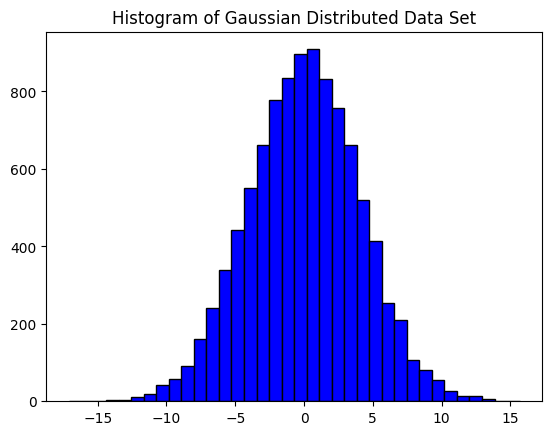

In [18]:
## Histogram of the array:

plt.hist(gaus, color = 'blue', edgecolor = 'black', bins = int(180/5))
plt.title('Histogram of Gaussian Distributed Data Set')
plt.show()

Point 3: The cumulative average is computed by taking the cumsum of the array diveded by a range from 1 to 10000:

In [19]:
## Cumulative average:

a = range(1,len(gaus)+1) # array of numbers from 1 to 10000
cumaverage = np.cumsum(gaus)/a # cumulative average of the gaussian distribution
print(cumaverage)

[-1.10737083  1.0090247  -1.11200379 ...  0.01337064  0.01270931
  0.01308633]


Point 4: The cumulative standard error is computed by expanding over the distribution array and respectively calculating the std, devided by the square-root of sample size/count. In order to expand, the array has to be converted into a dataframe. Also the first element is set to 0:

In [20]:
## Cumulative standard error:

df_gaus = pd.DataFrame(gaus, columns = ['Gaussian']) # dataframe of the gaussian distribution

cum_std_error = df_gaus['Gaussian'].expanding().std() / np.sqrt(df_gaus['Gaussian'].expanding().count()) 
cum_std_error[0] = 0  # set the first element to 0 # cumulative standard error of the pareto distribution
print('Cumulative Std:',np.array(cum_std_error))

Cumulative Std: [0.         2.11639553 2.44781642 ... 0.04039954 0.04040091 0.04039863]


Point 5: The mean and median of the gaussian distribution is computed:

In [21]:
print('mean:', np.mean(gaus)) # mean of the gaussian distribution
print('median:', np.median(gaus)) # median of the gaussian distribution

mean: 0.013086327249267915
median: 0.055950310111704545


Point 6: We now plot the cumulative average computed in point 3. as a line plot. Errorbars for each point in the graph are added equal to the standard error of the mean (orange color). Also a horizontal line corresponding to the distribution mean are added:

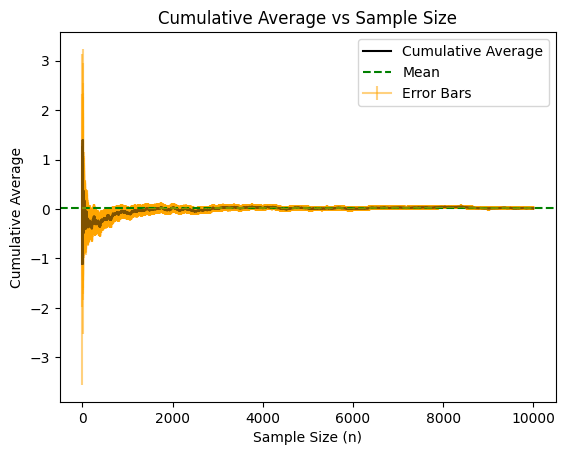

In [22]:
## Culimative average plot:

fig, ax = plt.subplots()

# Plot cumulative average as a line plot 
ax.errorbar(np.arange(10000), cumaverage, yerr=cum_std_error, color="orange", alpha=0.5, label='Error Bars') # Add errorbars to each point in the graph  
ax.plot(np.arange(10000), cumaverage, color='black', label='Cumulative Average') # Plot the cumulative average as a line plot
ax.axhline(y=np.mean(gaus), color='green', linestyle='--', label='Mean') # Add a horizontal line corresponding to the mean of "gaus"  

 # Set labels and title for the plot  
ax.set_title('Cumulative Average vs Sample Size')  
ax.set_xlabel('Sample Size (n)')  
ax.set_ylabel('Cumulative Average') 

 # Show legend and display plot 
plt.legend()  
plt.show()

Point 7: We now compute the cumulative median of the array, by simply expanding and calculating the median. This is done with the functions build-with-in pandas dataframe:

In [23]:
## Compute the cumulative median of the data set and store it in an array 

cumulative_median_gauss = df_gaus['Gaussian'].expanding().median()
print('Cumulative median:',np.array(cumulative_median_gauss))

Cumulative median: [-1.10737083  1.0090247  -1.10737083 ...  0.05595031  0.05538382
  0.05595031]


Point 8: The cumulative median computed in point 7. are now plottet as a line plot. A horizontal line corresponding to the distribution median are also added:

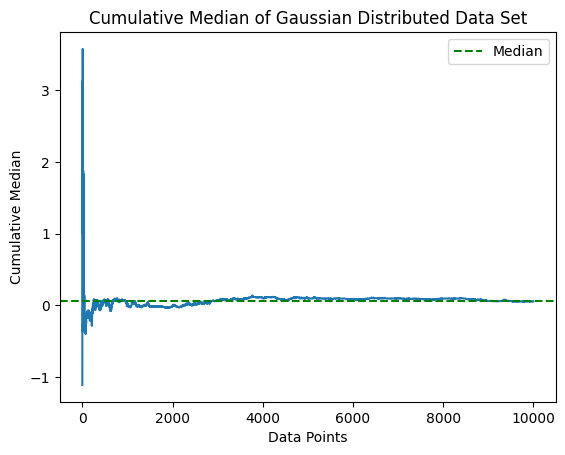

In [24]:
# Plot the cumulative median array:

plt.plot(cumulative_median_gauss)
plt.axhline(y=np.median(gaus), color='green', linestyle='--', label='Median')
plt.title('Cumulative Median of Gaussian Distributed Data Set')  
plt.xlabel('Data Points')  
plt.ylabel('Cumulative Median')
plt.legend()
plt.show()

# Pareto distribution:

Point 9: We now sample 10000 random numbers from a pareto distribution with alpha = 0.5 and x_m = 1:

In [25]:
N = 10000
alpha = 0.5
x_m = 1
pareto =  x_m*(np.random.pareto(alpha, N)+1)

Point 10: As we did for the gaussian distribution, a histrogram will be plottet, a dataframe of the array will be made, the cumulative average, median and standard error will be computed, a mean and median will be computed, and the the cumulative average and median will be plottet as a line plot.

To do this most efficient, a single output space will be made of point 2-8 on the pareto distribution. The values of the means, cumulatives, plots and such can be seen in the following output:

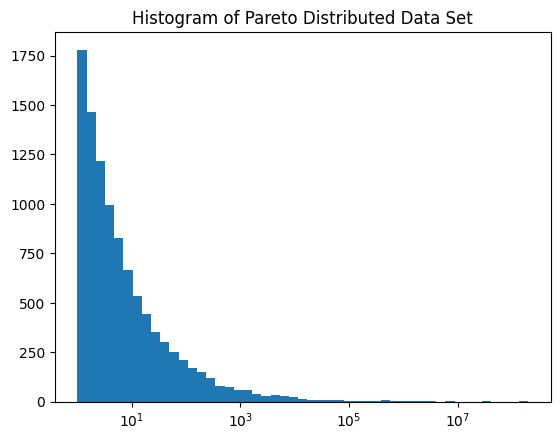

Cumulative Avg: [8.59813126e+00 4.90452684e+00 4.82531721e+01 ... 2.64293532e+04
 2.64267102e+04 2.64240676e+04]
      
Cumulative Std: [0.00000000e+00 3.69360442e+00 4.34010671e+01 ... 2.01716728e+04
 2.01696555e+04 2.01676386e+04]
      
mean: 26424.06759208506
median: 3.9298493196434903


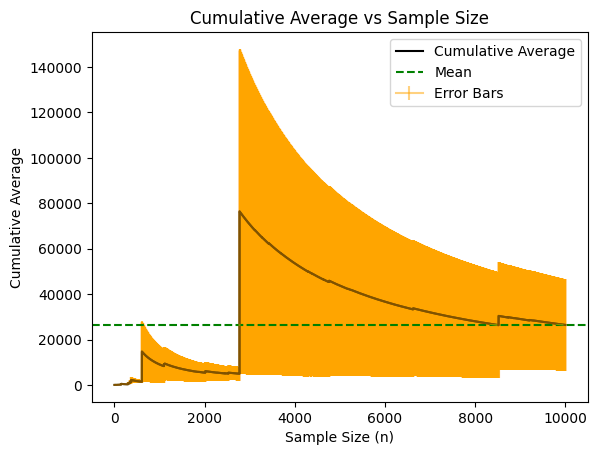

Cumulative median: [8.59813126 4.90452684 8.59813126 ... 3.93159034 3.93127163 3.92984932]


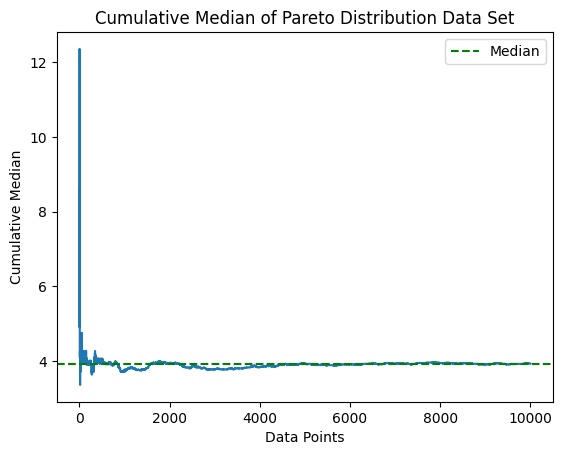

In [26]:
# Plot the histogram of the data 
plt.hist(pareto, bins=np.logspace(np.log10(min(pareto)), np.log10(max(pareto)), 50)) 
plt.gca().set_xscale("log") 
plt.title('Histogram of Pareto Distributed Data Set')  
plt.show()

# Create a dataframe from the array:
df_par = pd.DataFrame(pareto, columns=['Pareto'])

# Cumulative average
cumaverage_par = np.cumsum(pareto)/(range(1,len(pareto)+1))
print('Cumulative Avg:',cumaverage_par)

print("      ")

# Cumulative standard error using expanding() function (cumulative standard error of the mean)
cum_std_error_par = df_par['Pareto'].expanding().std() / np.sqrt(df_par['Pareto'].expanding().count()) 
cum_std_error_par[0] = 0  # set the first element to 0 # cumulative standard error of the pareto distribution
print('Cumulative Std:',np.array(cum_std_error_par))

print("      ")


# Compute mean and median of the data set:
print('mean:', np.mean(pareto))
print('median:', np.median(pareto))

# Culimative average plot:
fig, ax = plt.subplots()

# Plot cumulative average as a line plot 
ax.errorbar(np.arange(10000), cumaverage_par, yerr=cum_std_error_par, color="orange", alpha=0.5, label='Error Bars') # Add errorbars to each point in the graph  
ax.plot(np.arange(10000), cumaverage_par, color='black', label='Cumulative Average') # Plot the cumulative average as a line plot
ax.axhline(y=np.mean(pareto), color='green', linestyle='--', label='Mean') # Add a horizontal line corresponding to the mean 

# Set labels and title for the plot  
ax.set_title('Cumulative Average vs Sample Size')  
ax.set_xlabel('Sample Size (n)')  
ax.set_ylabel('Cumulative Average')  

 # Show legend and display plot 
plt.legend()  
plt.show()

# Compute the cumulative median of the data set and store it in an array 
cumulative_median_par = df_par['Pareto'].expanding().median()
print('Cumulative median:',np.array(cumulative_median_par))

# Plot the cumulative median array  
plt.plot(cumulative_median_par) 
plt.axhline(y=np.median(pareto), color='green', linestyle='--', label='Median')
plt.title('Cumulative Median of Pareto Distribution Data Set')  
plt.xlabel('Data Points')  
plt.ylabel('Cumulative Median')
plt.legend()
plt.show()


# Lognormal distribution

Point 11: We now sample 10000 random numbers from a lognormal distribution with mean 0 and standard deviation 4:

In [27]:
mu = 0
sigma = 4
N = 10000
lognor = np.random.lognormal(mean=mu, sigma=sigma, size=N)

Point 12: As mentioned in point 10, a single output space will be made of the results from 2-8 now on the lognormal distribution:

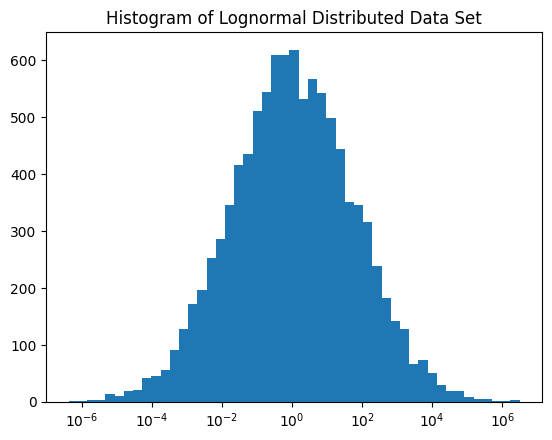

Cumulative Avg: [  14.84885389    7.66793369    5.11272618 ... 1931.30199136 1931.14560314
 1930.95305704]
      
Cumulative Std: [  0.           7.1809202    4.8700743  ... 539.95438313 539.90040225
 539.84644384]
      
mean: 1930.9530570438649
median: 1.0099364132729152


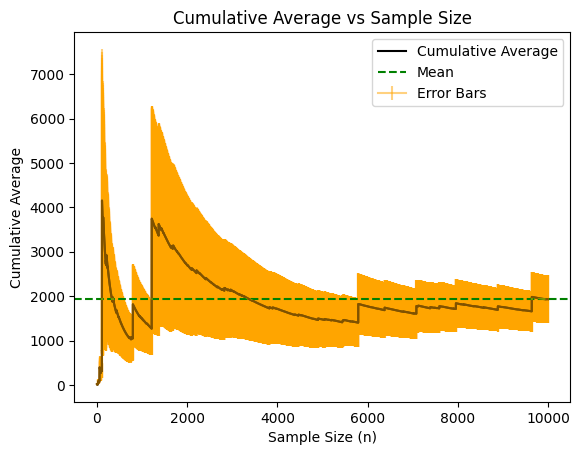

Cumulative median: [14.84885389  7.66793369  0.48701349 ...  1.00861029  1.0096144
  1.00993641]


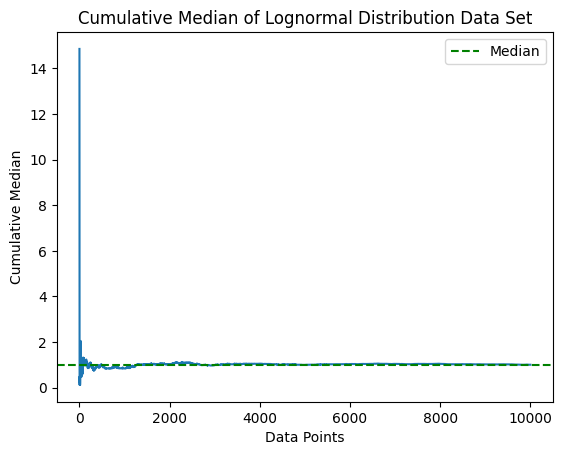

In [28]:
# Plot the histogram of the data 
plt.hist(lognor, bins=np.logspace(np.log10(min(lognor)), np.log10(max(lognor)), 50)) 
plt.gca().set_xscale("log")
plt.title('Histogram of Lognormal Distributed Data Set')  
plt.show()

# Create a dataframe from the array:
df_log = pd.DataFrame(lognor, columns=['Lognormal'])

# Cumulative average
cumaverage_lognor = np.cumsum(lognor)/(range(1,len(lognor)+1))
print('Cumulative Avg:',cumaverage_lognor)

print("      ")

# Cumulative standard error using expanding() function (cumulative standard error of the mean)
cum_std_error_lognor = df_log['Lognormal'].expanding().std() / np.sqrt(df_log['Lognormal'].expanding().count()) 
cum_std_error_lognor[0] = 0  # set the first element to 0 # cumulative standard error of the pareto distribution
print('Cumulative Std:',np.array(cum_std_error_lognor))

print("      ")

# Compute mean and median of the data set:
print('mean:', np.mean(lognor))
print('median:', np.median(lognor))

# Culimative average plot:
fig, ax = plt.subplots()

# Plot cumulative average as a line plot 
ax.errorbar(np.arange(10000), cumaverage_lognor, yerr=cum_std_error_lognor, color="orange", alpha=0.5, label='Error Bars') # Add errorbars to each point in the graph  
ax.plot(np.arange(10000), cumaverage_lognor, color='black', label='Cumulative Average') # Plot the cumulative average as a line plot
ax.axhline(y=np.mean(lognor), color='green', linestyle='--', label='Mean') # Add a horizontal line corresponding to the mean 

 # Set labels and title for the plot  
ax.set_title('Cumulative Average vs Sample Size')  
ax.set_xlabel('Sample Size (n)')  
ax.set_ylabel('Cumulative Average')  

 # Show legend and display plot 
plt.legend()  
plt.show()

# Compute the cumulative median of the data set and store it in an array
cumulative_median_lognor = df_log['Lognormal'].expanding().median()
print('Cumulative median:',np.array(cumulative_median_lognor))

# Plot the cumulative median array:
plt.plot(cumulative_median_lognor) 
plt.axhline(y=np.median(lognor), color='green', linestyle='--', label='Median')
plt.title('Cumulative Median of Lognormal Distribution Data Set')  
plt.xlabel('Data Points')  
plt.ylabel('Cumulative Median')  
plt.legend()
plt.show()

# Citations of papers from 2009

Point 13:

Note til Jonas. Koden ovenover producere resultaterne for point 2 til 8. Der skal bare ændres lidt i variablernes navne så den kan køres på citation data sættet. - mhh til point 14 altså.

Husk også at ændre i de forskellige teskter i print() :) 